In [ ]:
# Deconvolves 2D psfs, to remove effect of collimator

In [12]:
import numpy as np
from scipy import signal
from scipy.stats import norm
import matplotlib.pyplot as plt

In [ ]:
'''
Email from RZ, 2024 04 12:

Attached please find the spot diagram of your projector we assembled yesterday. The diamond turned off-axis parabola has astigmatism 
which was seen going in and out of focus and the resulting image has significant aberrations. FWHM is 6 pixels (5.2 micron each). 
This is certainly much over the diffraction limit which we would expected for a test beam which should be perfect to measure aberrations 
of the camera.

The camera image quality may be evaluated with the projector if the measured and magnified spot size of the projector input is 
de-convolved from the camera image. I obtained much smaller spot through the camera with the PSF mask at the camera focus.

The projector can be used for all other tests, in particular, field of view, repeatability etc. because we don’t care about PSF size 
and measure centroid on the detector only.
'''

In [10]:
def gaussian(x,x0,sigma):
  return np.exp(-np.power((x - x0)/sigma, 2.)/2.)

In [14]:
# fake signal
abcissa_true_signal = np.linspace(0,100,101)
# Create a Gaussian distribution based on abcissa_true_signal
ordinate_true_signal = gaussian(abcissa_true_signal, x0=50, sigma=2)

# impulse response
ordinate_impulse_response = gaussian(abcissa_true_signal, x0=50, sigma=10)

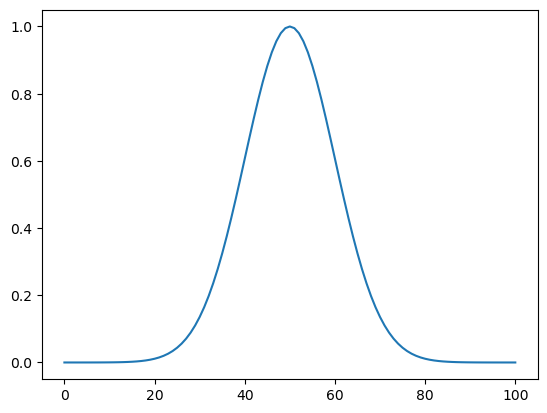

In [13]:
plt.plot(abcissa_true_signal, ordinate_true_signal, label='true signal')
plt.plot(abcissa_true_signal, ordinate_impulse_response, label='impulse response')
#plt.plot(abcissa_true_signal, ordinate_impulse_response, label='convolved')
#plt.plot(abcissa_true_signal, ordinate_impulse_response, label='deconvolved')
plt.show()

In [8]:
# ex.

original = [0, 1, 0, 0, 1, 1, 0, 0]
impulse_response = [2, 1]

recorded = signal.convolve(impulse_response, original)
print(recorded)


recovered, remainder = signal.deconvolve(recorded, impulse_response)
print(recovered)

[0 2 1 0 2 3 1 0 0]
[0. 1. 0. 0. 1. 1. 0. 0.]


In [7]:
abcissa

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100.])

In [ ]:


f, r = signal.deconvolve(s, s_f)